In [1]:
import torch
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 32
volume = lattice_size ** 2
beta = 7
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 2048

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/200 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 2048/2048 [00:23<00:00, 87.50it/s]


>>> Simulation completed


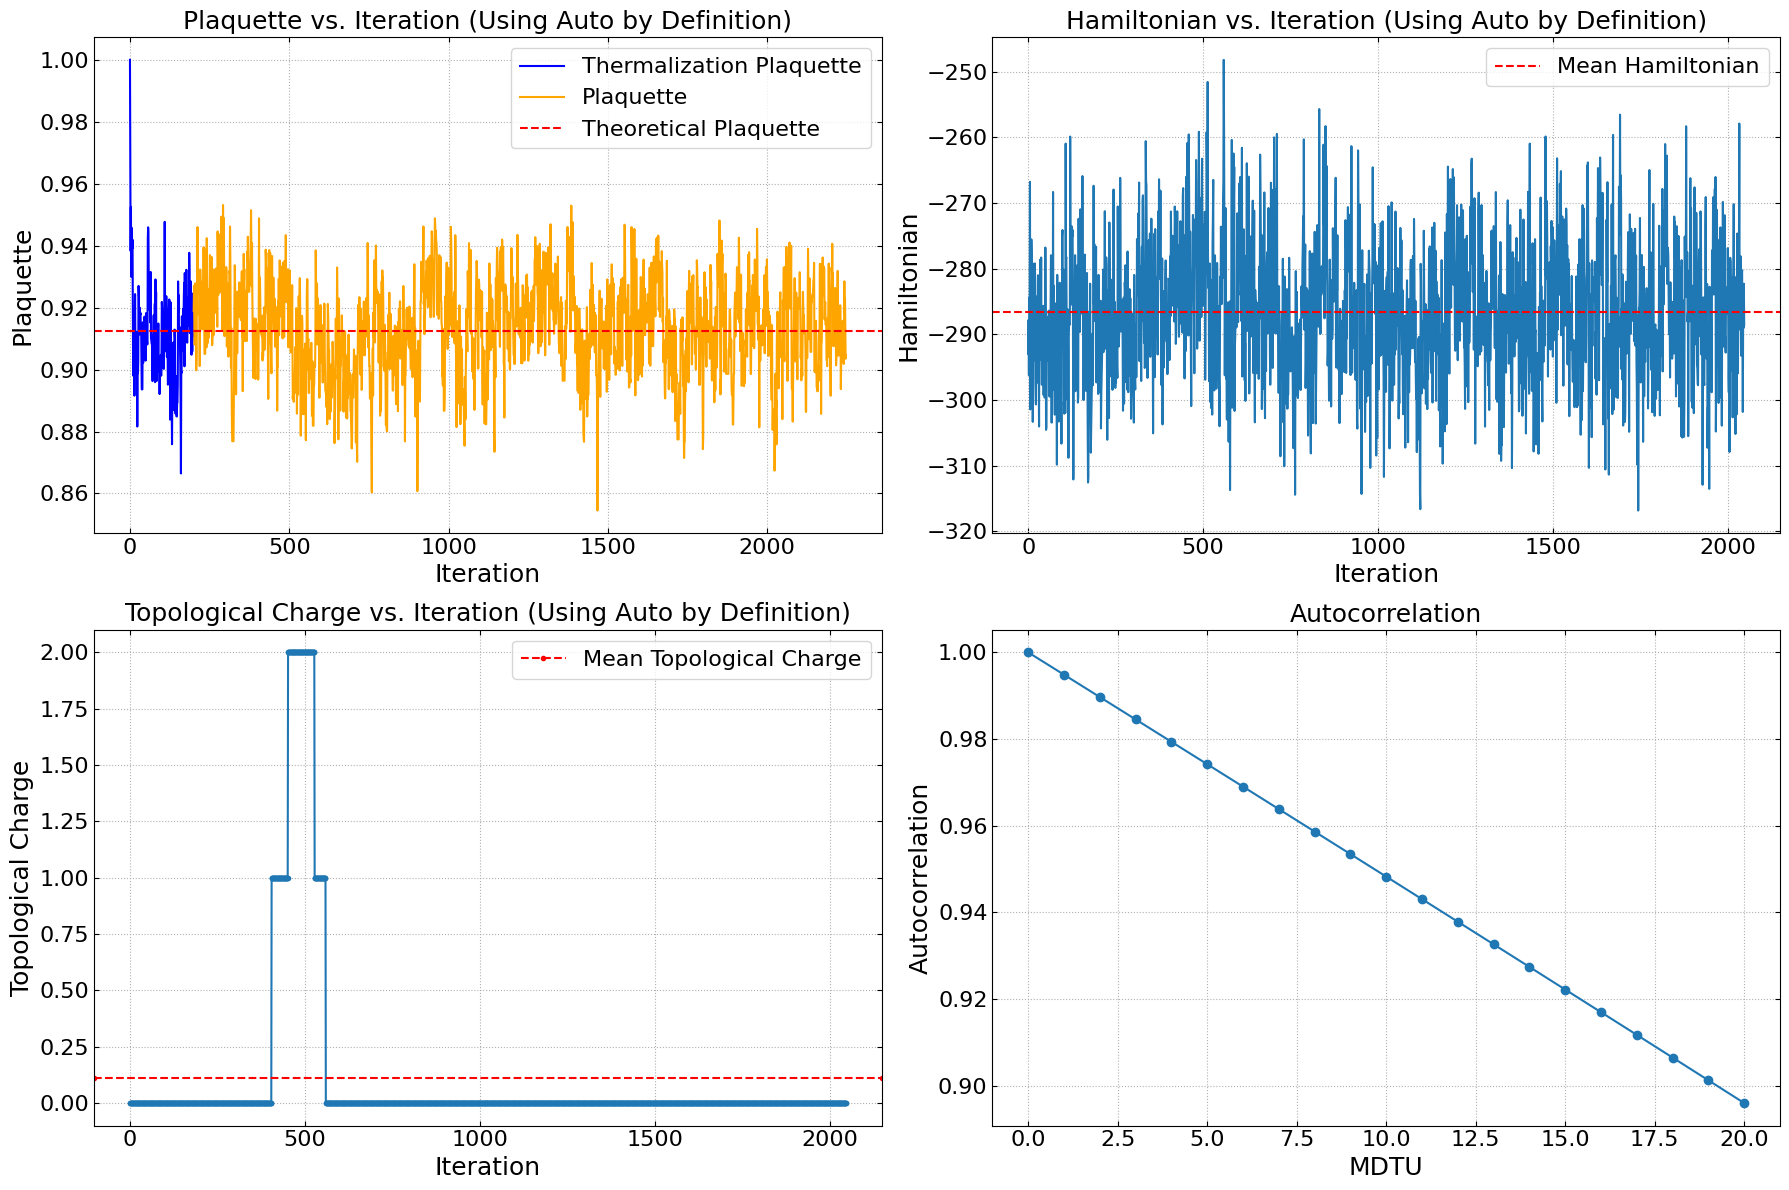

>>> Theoretical plaquette:  0.9123593043529149
>>> Mean plaq:  0.91339903746848
>>> Std of mean plaq:  0.00033548813002248214
Thermalization acceptance rate: 0.9000
Acceptance rate: 0.8574


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_L{lattice_size}_beta{beta}.pdf', transparent=True)

# Save configurations for training
np.save(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

In [5]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8, if_check_jac=True) #todo
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
print(">>> Training the model")
nn_ft.train(train_data, test_data, beta, n_epochs=16, batch_size=16)

# Save the trained models
print(">>> Saving the trained models")
save_dict = {}
for i, model in enumerate(nn_ft.models):
    save_dict[f'model_{i}'] = model.state_dict()
torch.save(save_dict, 'models/cnn_trained.pt')
print(">>> Models saved successfully")

# Load the trained models
print(">>> Loading the trained models")
saved_models = torch.load('models/cnn_trained.pt')
for i, model in enumerate(nn_ft.models):
    model.load_state_dict(saved_models[f'model_{i}'])
    model.eval()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_ft_L{lattice_size}_beta{beta}.pdf', transparent=True)


>>> Neural Network Field Transformation HMC Simulation: 
Loaded data shape: torch.Size([2048, 2, 8, 8])
Training data shape: torch.Size([1638, 2, 8, 8])
Testing data shape: torch.Size([410, 2, 8, 8])
>>> Training the model


Training epochs:   0%|          | 0/16 [00:00<?, ?it/s]

Jacobian log determinant by hand is 4.26e+00
Jacobian log determinant by autograd is -1.02e+00
Jacobian is all gooood


Jacobian log determinant by hand is 3.79e+00
Jacobian log determinant by autograd is -1.04e+00
Jacobian is all gooood


Jacobian log determinant by hand is 4.16e+00
Jacobian log determinant by autograd is -1.19e+00
Jacobian is all gooood


Jacobian log determinant by hand is 4.13e+00
Jacobian log determinant by autograd is -1.49e+00
Jacobian is all gooood


Training epochs:   0%|          | 0/16 [00:08<?, ?it/s]


KeyboardInterrupt: 